<a href="https://colab.research.google.com/github/WPHdamian/Data-Science-Curriculum-Analysis-/blob/main/curriculum_analysis_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Import libraries and datasets

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
df = pd.read_excel('Data Science Curricula.xlsx')
df.head(2)

,City,Univeristy,Program_Name,Faculty,Level,Module_Code,Module_Title,Module_Description,Core_or_Elective,Link
0,HK,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4301,Corporate Accounting II,This course aims to:\n\ndevelop students' conc...,0,https://www.cb.cityu.edu.hk/dao/bbabda/intro
1,HK,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4342,Auditing,The primary objective of this course is to pro...,0,https://www.cb.cityu.edu.hk/dao/bbabda/intro


In [4]:
# rename columns to more codable names
df.columns = df.columns.str.lower()
df.columns

Index(['city', 'univeristy', 'program_name', 'faculty', 'level', 'module_code',
       'module_title', 'module_description', 'core_or_elective', 'link'],
      dtype='object')

In [5]:
# We drop the `Link` column
df = df[['city', 'univeristy', 'program_name', 'faculty', 'level', 'module_code','module_title', 'module_description', 'core_or_elective',]]
df.columns

Index(['city', 'univeristy', 'program_name', 'faculty', 'level', 'module_code',
       'module_title', 'module_description', 'core_or_elective'],
      dtype='object')

## Initial inspection and Cleaning

In [6]:
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   city                1621 non-null   object
 1   univeristy          1621 non-null   object
 2   program_name        1621 non-null   object
 3   faculty             1621 non-null   object
 4   level               1621 non-null   object
 5   module_code         1190 non-null   object
 6   module_title        1621 non-null   object
 7   module_description  1586 non-null   object
 8   core_or_elective    1621 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 114.1+ KB


,0
city,0
univeristy,0
program_name,0
faculty,0
level,0
module_code,431
module_title,0
module_description,35
core_or_elective,0


We can observe that there are 35 null values (2%) in `module_description`. We can drop those rows. For `module_code`, pseudo IDs will be created for future uses.

In [7]:
# Drop NA values from module_description
df.dropna(subset=['module_description'], inplace=True)
df.isnull().sum()

,0
city,0
univeristy,0
program_name,0
faculty,0
level,0
module_code,424
module_title,0
module_description,0
core_or_elective,0


Next we deal with duplicate values. During data collection, we can observe that many university have share modules/courses which may hinder our analysis. Let's first mark them in a new column `is_shared_module`

In [8]:
# Double check dup values
df[df.duplicated(keep=False)].head()

,city,univeristy,program_name,faculty,level,module_code,module_title,module_description,core_or_elective
1099,London,London School of Economics and Political Science,Bsc in Data Science,Department of Statistics,Bachelor,MA103,Introduction to Abstract Mathematics,The course is an introduction to the use of fo...,0
1100,London,London School of Economics and Political Science,Bsc in Data Science,Department of Statistics,Bachelor,MA103,Introduction to Abstract Mathematics,The course is an introduction to the use of fo...,0
1570,London,Imperial College London,Msc in Statistics (Data Science and Machine Le...,Department of Mathematics,Master,NaN,Statistical Learning for high-dimensional data,Appreciate the importance of handling high dim...,0
1571,London,Imperial College London,Msc in Statistics (Data Science and Machine Le...,Department of Mathematics,Master,NaN,Statistical Learning for high-dimensional data,Appreciate the importance of handling high dim...,0


In [9]:
x = len(df)

# Only drop exact duplicates (identical across all columns)
df.drop_duplicates(inplace=True)

print(f"Deleted {x - len(df)} columns")

Deleted 2 columns


Next, since `module_code` has missing values, it cannot be used as a primary key. Therefore, we create a new column `module_id` and we calculate `is_shared_module` from it.

In [10]:
# Set temporary key
df["module_id"] = (
    df["univeristy"].astype(str).str.strip().str.lower() + "_" +
    df["module_title"].astype(str).str.strip().str.lower()
)

# Flag
shared_counts = df.groupby(["univeristy", "module_title"]).size().reset_index(name="program_count")

# Merge flag back in
df = df.merge(shared_counts, on=["univeristy", "module_title"], how="left")
df["is_shared_module"] = df["program_count"].apply(lambda x: 1 if x > 1 else 0)
df.head(2)

,city,univeristy,program_name,faculty,level,module_code,module_title,module_description,core_or_elective,module_id,program_count,is_shared_module
0,HK,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4301,Corporate Accounting II,This course aims to:\n\ndevelop students' conc...,0,cityu_corporate accounting ii,1,0
1,HK,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4342,Auditing,The primary objective of this course is to pro...,0,cityu_auditing,1,0


In [11]:
# Check if the fucntion works
df["program_count"].unique()

array([1, 2, 3, 5, 4, 8])

## Mapping columns `city` and `core_elective` for calrity

In [12]:
# Map city codes
df["city"] = df["city"].replace({"HK": "Hong Kong"})

# Map 'core_or_elective'
df["core_or_elective"] = df["core_or_elective"].map({1: "Core", 0: "Elective"})

df["city"].unique()
df["core_or_elective"].unique()

array(['Elective', 'Core'], dtype=object)

Next, before we move onto NLP. We create a new column `text_combined` that will be used in analysis

In [13]:
df["text_combined"] = df["module_title"].fillna("") + " " + df["module_description"].fillna("")

## Basic Text Preprocessing

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # lowercase
    text = text.lower()
    # remove punctuation/numbers
    text = re.sub(r"[^a-z\s]", " ", text)
    # tokenize, remove stopwords, lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text_combined"].apply(clean_text)


The `clean_text` column will be used

Finally we save the cleaned dataset as `cleaned_curriculum_dataset.csv`

In [15]:
df.to_csv("cleaned_curriculum_dataset.csv", index=False)

In [16]:
# final review
df.head()

,city,univeristy,program_name,faculty,level,module_code,module_title,module_description,core_or_elective,module_id,program_count,is_shared_module,text_combined,clean_text
0,Hong Kong,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4301,Corporate Accounting II,This course aims to:\n\ndevelop students' conc...,Elective,cityu_corporate accounting ii,1,0,Corporate Accounting II This course aims to:\n...,corporate accounting ii course aim develop stu...
1,Hong Kong,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4342,Auditing,The primary objective of this course is to pro...,Elective,cityu_auditing,1,0,Auditing The primary objective of this course ...,auditing primary objective course provide stud...
2,Hong Kong,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2100,Introduction to Financial Accounting,This course aims to:\n\nprovide students with ...,Core,cityu_introduction to financial accounting,1,0,Introduction to Financial Accounting This cour...,introduction financial accounting course aim p...
3,Hong Kong,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2101,Introduction to Managerial Accounting,This course aims to: 1.provide students with b...,Core,cityu_introduction to managerial accounting,1,0,Introduction to Managerial Accounting This cou...,introduction managerial accounting course aim ...
4,Hong Kong,CityU,Bsc in Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2200,Business Statistics,This course aims to facilitate students' learn...,Core,cityu_business statistics,1,0,Business Statistics This course aims to facili...,business statistic course aim facilitate stude...


# Text Mining and NLP techniques

## Frequency analysis

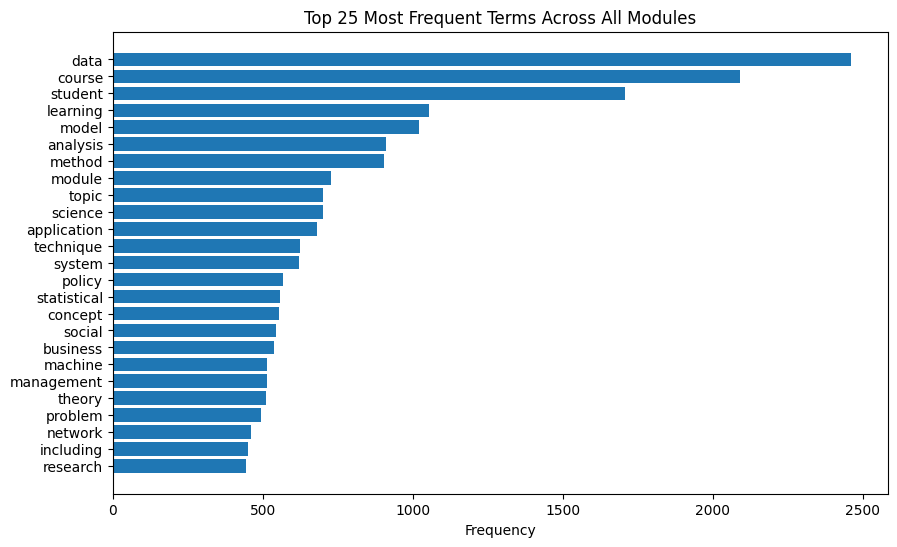

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

# Tokenise and count
df["tokens"] = df["clean_text"].apply(lambda x: x.split())
all_tokens = [t for tokens in df["tokens"] for t in tokens]
word_freq = Counter(all_tokens)

# Convert to DataFrame
freq_df = pd.DataFrame(word_freq.most_common(25), columns=["term", "frequency"])

# Plot
plt.figure(figsize=(10,6))
plt.barh(freq_df["term"], freq_df["frequency"])
plt.gca().invert_yaxis()
plt.title("Top 25 Most Frequent Terms Across All Modules")
plt.xlabel("Frequency")
plt.show()


We can observe that many keywords may be unrelated to our research. Let's remove them to see if there are any other insights.

In [18]:
custom_stopwords = [
    "course", "student", "module", "learning", "science",
    "concept", "topic", "study", "programme", "knowledge",
    "introduction", "including", "method", "approach", "example",
    "also", "basic", "cover", "include", "using", "use", "skill",
    "learn", "understanding", "principle", "aim"
]

# Apply removal
df["clean_text"] = df["clean_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in custom_stopwords])
)


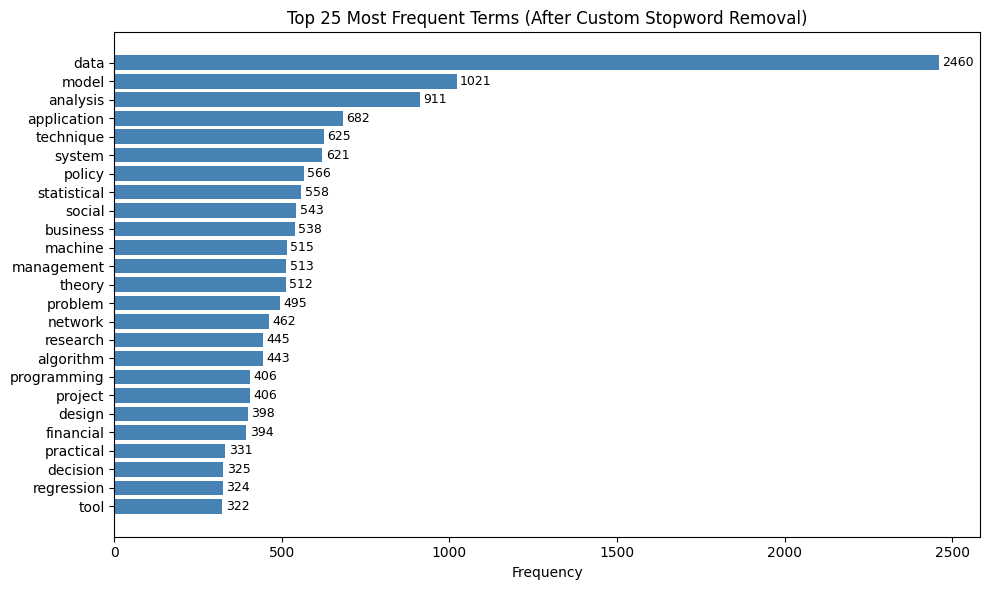

In [19]:
# Tokenize all words in your cleaned corpus
all_words = " ".join(df["clean_text"]).split()

# Count word frequencies
word_freq = Counter(all_words)
most_common = word_freq.most_common(25)

# Convert to two lists
words, counts = zip(*most_common)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(words, counts, color='steelblue')
plt.xlabel("Frequency")
plt.title("Top 25 Most Frequent Terms (After Custom Stopword Removal)")
plt.gca().invert_yaxis()  # Highest frequency at top

# Add count labels next to bars
for bar, count in zip(bars, counts):
    plt.text(count + 10, bar.get_y() + bar.get_height()/2, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Skill Keyword Mapping

We first define our skill dictionary. For the midterm report, I will use a simpler version of the LinkedIn Skill Summary. In the future, the list will be expanded based on literature and findings.

In [20]:
skill_dict = {
    "technical": [
        "python", "r", "sql", "machine learning", "deep learning",
        "algorithm", "data mining", "data warehouse", "database",
        "big data", "spark", "hadoop", "cloud computing"
    ],
    "analytical": [
        "problem solving", "decision making", "modelling", "model",
        "statistics", "statistical", "analysis", "prediction", "evaluation"
    ],
    "business": [
        "business analytics", "business intelligence", "domain knowledge",
        "project management", "management", "industry", "application",
        "strategy", "consulting"
    ],
    "soft": [
        "communication", "teamwork", "leadership", "presentation",
        "writing", "collaboration", "ethical", "ethics", "team work"
    ]
}

# Processing just in case
for cat in skill_dict:
    skill_dict[cat] = list(set([kw.lower() for kw in skill_dict[cat]]))

In [21]:
def count_keywords(text, keywords):
    count = 0
    for kw in keywords:
        # Using simple substring matching
        count += text.count(kw)
    return count

for category, keywords in skill_dict.items():
    df[f"{category}_count"] = df["clean_text"].apply(lambda x: count_keywords(x, keywords))

We also noticed that some modules have relatively longer descriptions. Therefore, we normalise it by description length

In [22]:
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
for category in skill_dict.keys():
    df[f"{category}_norm"] = df[f"{category}_count"] / df["word_count"]

We find the mean of all categories by city

In [23]:
city_summary = df.groupby("city").agg(
    technical_avg = ("technical_count", "mean"),
    analytical_avg = ("analytical_count", "mean"),
    business_avg = ("business_count", "mean"),
    soft_avg = ("soft_count", "mean"),
    technical_norm_avg = ("technical_norm", "mean"),
    analytical_norm_avg = ("analytical_norm", "mean"),
    business_norm_avg = ("business_norm", "mean"),
    soft_norm_avg = ("soft_norm", "mean"),
    modules_count = ("module_id", "count")
).reset_index()

city_summary

,city,technical_avg,analytical_avg,business_avg,soft_avg,technical_norm_avg,analytical_norm_avg,business_norm_avg,soft_norm_avg,modules_count
0,Hong Kong,24.096244,1.901408,1.207746,0.200704,0.486842,0.043632,0.027886,0.003896,852
1,London,36.790984,2.500000,0.710383,0.230874,0.518626,0.040592,0.011392,0.003073,732


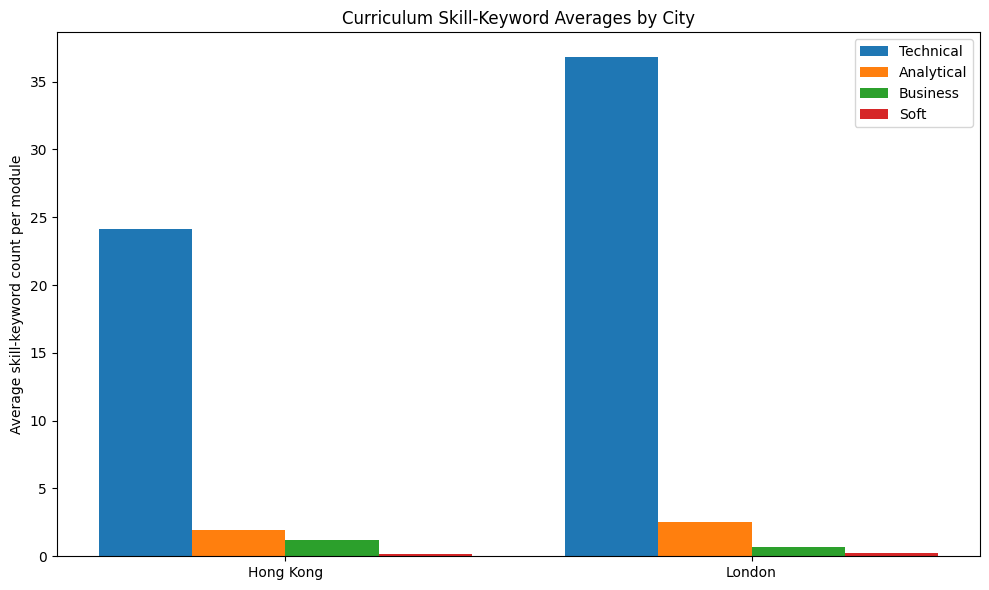

In [24]:
import matplotlib.pyplot as plt

categories = ["technical_avg","analytical_avg","business_avg","soft_avg"]
x = np.arange(len(city_summary["city"]))  # number of cities
width = 0.2

plt.figure(figsize=(10,6))
for i, cat in enumerate(categories):
    plt.bar(x + i*width, city_summary[cat], width, label=cat.replace("_avg","").capitalize())

plt.xticks(x + width*1.5, city_summary["city"])
plt.ylabel("Average skill-keyword count per module")
plt.title("Curriculum Skill-Keyword Averages by City")
plt.legend()
plt.tight_layout()
plt.show()

## Topic Modelling (Latent Thematic Analysis)

First we import libraries

In [25]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.6 MB/s eta 0:00:00


In [26]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
texts = [text.split() for text in df["clean_text"].tolist()]
id2word = corpora.Dictionary(texts)
corpus_gensim = [id2word.doc2bow(text) for text in texts]

vectorizer = CountVectorizer(
    max_df = 0.8,        # >80% of documents
    min_df = 5,          # fewer than 5 documents
    stop_words = 'english'  # ensure your custom stopwords are already removed
)
X = vectorizer.fit_transform(df["clean_text"])

# Fit LDA (sklearn)
n_topics = 5 # 7, 9, 11
lda_model = LatentDirichletAllocation(
    n_components = n_topics,
    max_iter = 10,
    learning_method = 'online',
    random_state = 42,
    verbose = 1
)
lda_model.fit(X)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

iteration: 1 of max_iter: 10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

iteration: 2 of max_iter: 10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

iteration: 3 of max_iter: 10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
feature_names = vectorizer.get_feature_names_out()
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_terms = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx + 1}: {' | '.join(top_terms)}")

display_topics(lda_model, feature_names, no_top_words=10)

In [ ]:
# Assign dominant topic for each module/document
doc_topic_dist = lda_model.transform(X)
df["dominant_topic"] = doc_topic_dist.argmax(axis=1) + 1
df["topic_probability"] = doc_topic_dist.max(axis=1)

# Topic distribution by city
topic_counts = df.groupby(["city", "dominant_topic"]).size().unstack(fill_value=0)
topic_dist = topic_counts.div(topic_counts.sum(axis=1), axis=0)
print(topic_dist)

topic_dist.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel("Proportion of Modules")
plt.title("Distribution of Dominant Topics by City")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Next we calculate the coherence score with the `Gensim` Library.

In [ ]:
lda_gensim = gensim.models.LdaModel(
    corpus = corpus_gensim,
    id2word = id2word,
    num_topics = n_topics,
    random_state = 42,
    passes = 10,
    alpha = 'auto'
)
coherence_model = CoherenceModel(
    model = lda_gensim,
    texts = texts,
    dictionary = id2word,
    coherence = 'c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score (c_v): {coherence_score:.4f}")

Visualization

In [ ]:
# Interactive visualization with pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_gensim, corpus_gensim, id2word)
vis  # Displays interactive view in notebook
